# Sheet 8

In [1]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 1) Anomaly detection for Autoencoders

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: 07AE-1B93

 Verzeichnis von c:\Users\Games\OneDrive\Desktop\mlph2023-Exercises\data06

28.12.2023  19:53    <DIR>          .
28.12.2023  19:53    <DIR>          ..
25.12.2023  13:52    <DIR>          toptagging-short
25.12.2023  13:52        68.105.824 toptagging-short (1).zip
28.12.2023  13:09        68.105.824 toptagging-short (10).zip
28.12.2023  16:19        68.105.824 toptagging-short (11).zip
28.12.2023  16:22        68.105.824 toptagging-short (12).zip
28.12.2023  19:47        68.105.824 toptagging-short (13).zip
28.12.2023  19:53        68.105.824 toptagging-short (14).zip
25.12.2023  13:52        68.105.824 toptagging-short (2).zip
25.12.2023  13:52        68.105.824 toptagging-short (3).zip
25.12.2023  13:52        68.105.824 toptagging-short (4).zip
25.12.2023  13:52        68.105.824 toptagging-short (5).zip
25.12.2023  13:52        68.105.824 toptagging-short (6).zip
25.12.2023  14:02        68.105.824 topt

In [3]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")
X_train_qcd = X_train[ y_train == 0.0 ]
X_val_qcd = X_val[ y_val == 0.0 ]
print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [5]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_train_qcd = constit_to_img( X_train_qcd, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_val_qcd = constit_to_img( X_val_qcd, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


In [6]:
z_train_p = torch.Tensor( z_train )
z_train_qcd_p = torch.Tensor( z_train_qcd )
z_val_p = torch.Tensor( z_val )
z_val_qcd_p = torch.Tensor( z_val_qcd )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

In [7]:
class topcloud_bkg_dataset( Dataset ):
    
    def __init__( self, data ):
        self.data = data
        self.labels = torch.Tensor( [ 0.0 for i in range(len(data)) ] )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
class topcloud_sig_dataset( Dataset ):
    
    def __init__( self, data, labels ):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [8]:
trn_dataset = topcloud_bkg_dataset( z_train_qcd_p )
val_dataset = topcloud_bkg_dataset( z_val_qcd_p )
tst_dataset = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [9]:

trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

(a)

In [10]:
# TODO: Construct autoencoder
class JetAutoEncoder(nn.Module):
    def __init__(self,data_dim,bottleneck_dim,hidden_dim):
            super(JetAutoEncoder,self).__init__()
            self.encoderlayer1 =  nn.Linear(data_dim,hidden_dim)
            self.encoderlayer2 = nn.Linear(hidden_dim,hidden_dim)
            self.encoderlayer3 = nn.Linear(hidden_dim,bottleneck_dim)
            self.decoderlayer1 = nn.Linear(bottleneck_dim,hidden_dim)
            self.decoderlayer2 = nn.Linear(hidden_dim,hidden_dim)
            self.decoderlayer3 = nn.Linear(hidden_dim,data_dim)
            self.relu=nn.ReLU()
    def forward(self,x):
        x =  x.view(x.size(0), -1)
        x = self.encoderlayer1(x)
        x=self.relu(x)
        x = self.encoderlayer2(x)
        x=self.relu(x)
        x = self.encoderlayer3(x)
        x = self.decoderlayer1(x)
        self.relu(x)
        x = self.decoderlayer2(x)
        self.relu(x)
        x = self.decoderlayer3(x)
        return x.view(-1,1,40,40)
    def train_model(self, train_loader,val_loader, epochs, optimizer, loss_func, train_loss=[], val_loss=[]):
        self.train_loss=train_loss
        self.val_loss=val_loss
        for epoch in range(epochs):
            self.train()
            for x,y in train_loader:
                optimizer.zero_grad()
                output=self.forward(x)
                loss=loss_func(output,x)
                loss.backward()
                optimizer.step()
                self.train_loss.append(loss.item())
            self.eval()
            for x,y in val_loader:
                epoch_losses=[]
                with torch.no_grad():
                    output=self.forward(x)
                    loss=loss_func(output,x)
                    epoch_losses.append(loss.item())
            self.val_loss.append(np.mean(epoch_losses))
                 


(b)

In [11]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20
model= JetAutoEncoder(1600,20,400)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss_function=nn.MSELoss()
model.train_model(train_loader=trn_dataloader,val_loader=val_dataloader,epochs=100,optimizer=optimizer,loss_func=loss_function)

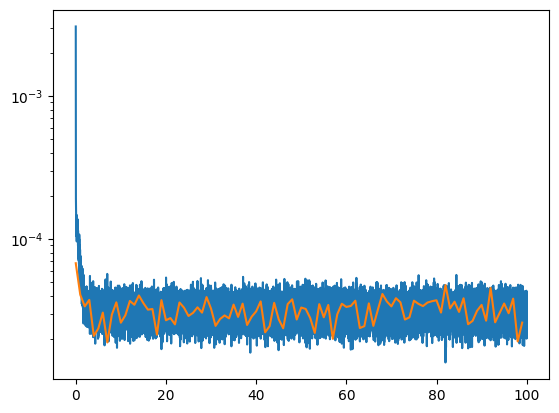

In [12]:
plt.plot(np.arange(len(model.train_loss)) / len(trn_dataloader), model.train_loss)
plt.plot(np.arange(len(model.val_loss)), model.val_loss)
plt.yscale("log")
plt.show()

In [13]:
model.val_loss[-1]

2.5998579076258466e-05

(c)

In [14]:
# TODO: Visualize original vs reconstructed QCD and top jets
# Choose a few jets to visualize
qcd_sample=z_test_p[y_test_p==0][:4]
top_sample=z_test_p[y_test_p==1][:4]
qcd_reconstructed=model.forward(qcd_sample)
top_reconstructed=model.forward(top_sample)

In [15]:

def visualize_matrices(matrices, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(matrices[i], cmap='gist_heat_r',vmin=0,vmax=0.5)
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


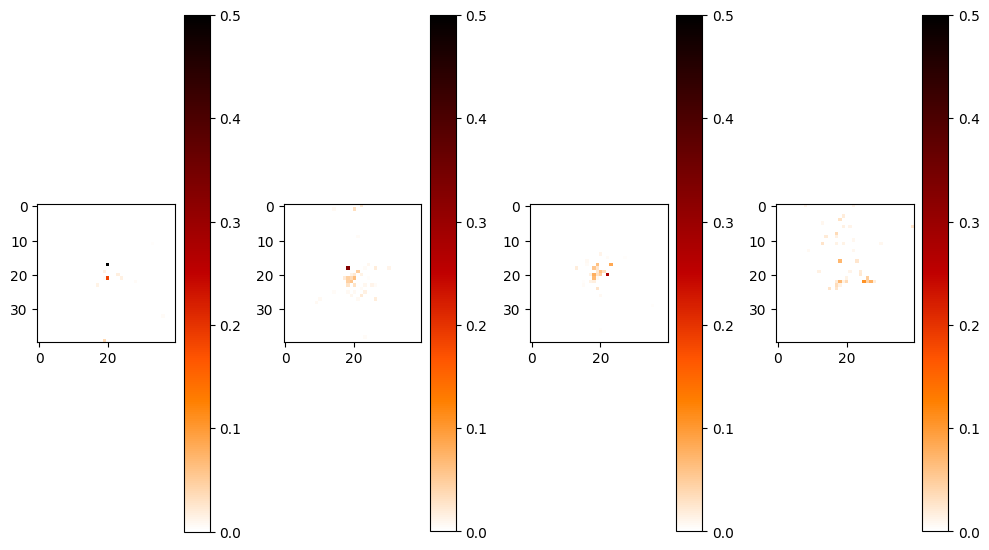

In [16]:
visualize_matrices(qcd_sample.reshape(-1, 40, 40).detach().numpy(), 1, 4)

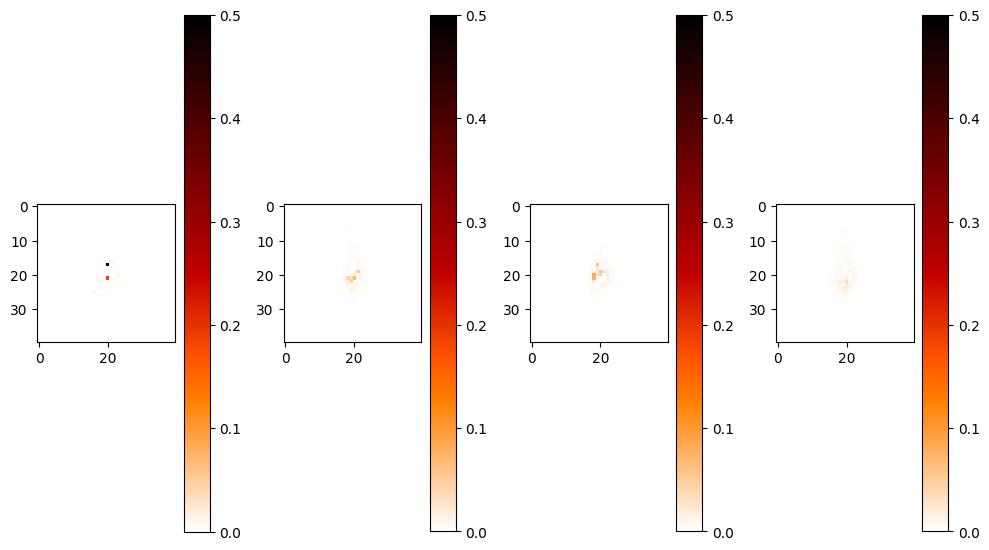

In [17]:
visualize_matrices(qcd_reconstructed.reshape(-1, 40, 40).detach().numpy(), 1, 4)

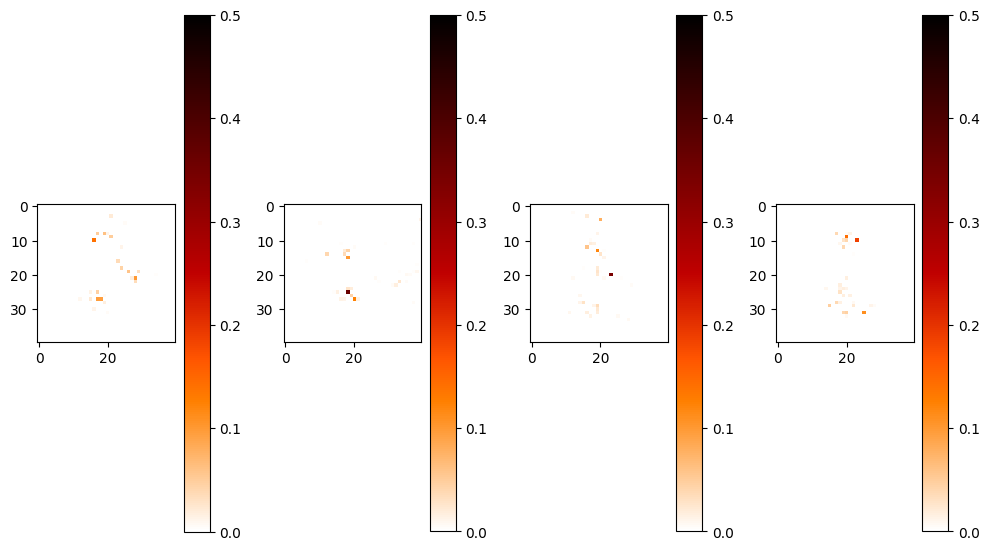

In [18]:
visualize_matrices(top_sample.reshape(-1, 40, 40).detach().numpy(), 1, 4)

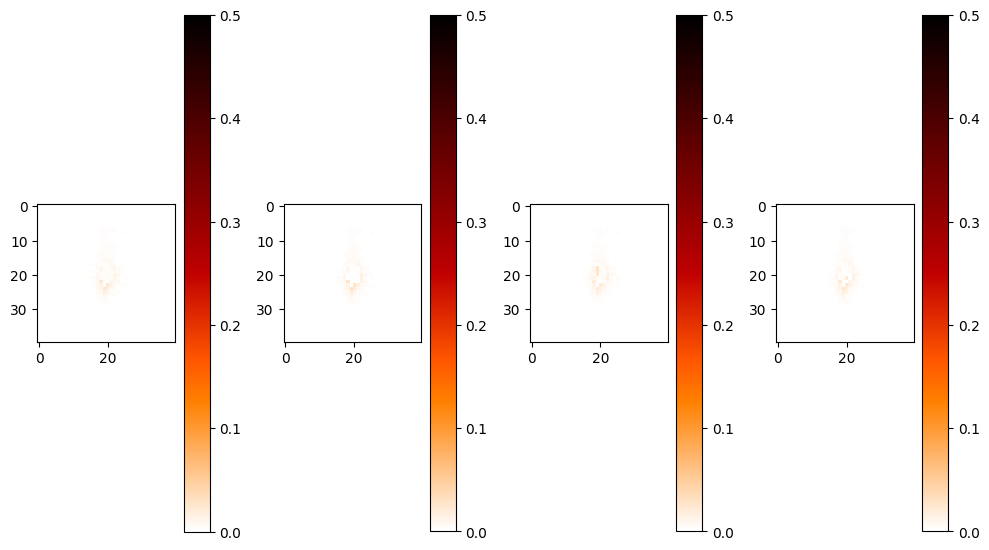

In [19]:
visualize_matrices(top_reconstructed.reshape(-1, 40, 40).detach().numpy(), 1, 4)

(d)

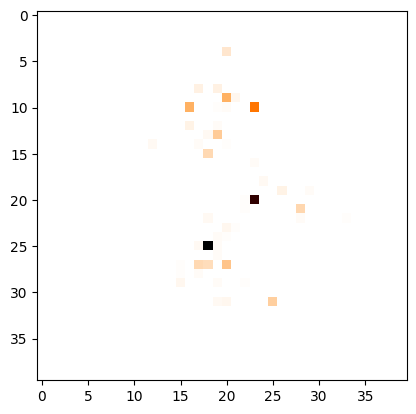

In [20]:
# TODO: Visualize pixel-wise MSE, plot ROC
mse_top = ((top_sample - top_reconstructed)**2).mean(axis=0)
mse_qcd = ((qcd_sample - qcd_reconstructed)**2).mean(axis=0)
plt.imshow(mse_top.reshape(40, 40).detach().numpy(), cmap="gist_heat_r")

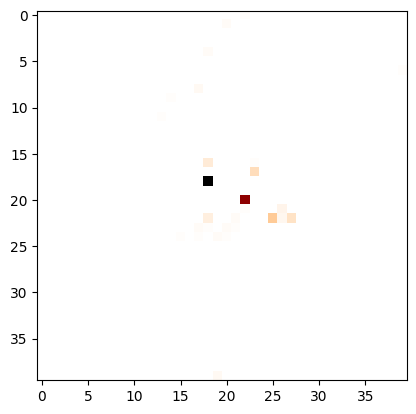

In [21]:
plt.imshow(mse_qcd.reshape(40, 40).detach().numpy(), cmap="gist_heat_r")

In [22]:
((top_sample - top_reconstructed)**2).shape

torch.Size([4, 1, 40, 40])

In [23]:
mse_top

tensor([[[8.4716e-10, 1.6947e-08, 1.5219e-08,  ..., 1.4505e-08,
          1.4223e-08, 6.3987e-08],
         [2.6025e-08, 1.2765e-08, 3.1365e-09,  ..., 3.9153e-08,
          9.2248e-09, 6.1800e-09],
         [2.6327e-09, 7.3250e-08, 2.1097e-10,  ..., 1.0756e-08,
          2.4592e-08, 2.2635e-08],
         ...,
         [6.4228e-09, 2.0202e-09, 4.0031e-10,  ..., 5.0516e-09,
          2.4395e-09, 2.9459e-08],
         [3.3744e-10, 9.1251e-09, 3.8529e-09,  ..., 9.4013e-08,
          1.5762e-08, 1.8377e-09],
         [1.1131e-08, 4.9932e-09, 2.2927e-10,  ..., 3.1997e-08,
          1.1896e-08, 4.4152e-08]]], grad_fn=<MeanBackward1>)

(e)

In [24]:
from tqdm import tqdm
# TODO: Repeat everything for CNN
class CNN_AC(nn.Module):
    def __init__(self, bottleneck_dim) -> None:
        super(CNN_AC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=5, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=5, out_channels=1, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(400, 100),
            nn.ReLU(),
            nn.Linear(100, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 400),
            nn.ReLU(),
            nn.Unflatten(1, (1, 20, 20)),
            nn.Conv2d(in_channels=1, out_channels=5, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=5, out_channels=10, stride=1, kernel_size=3, padding=1),
            nn.ConvTranspose2d(in_channels=10, out_channels=10, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=1, stride=1, kernel_size=3, padding=1)
        )

    def train_model(self, train_loader, val_loader, epochs, optimizer, loss_func, train_loss=[], val_loss=[]):
        self.train_loss = train_loss
        self.val_loss = val_loss
        for epoch in range(epochs):
            self.train()
            train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for x, y in train_bar:
                optimizer.zero_grad()
                output = self.forward(x)
                loss = loss_func(output, x)
                loss.backward()
                optimizer.step()
                self.train_loss.append(loss.item())
                train_bar.set_postfix({"Loss": loss.item()})
            self.eval()
            val_losses = []
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc="Validation", leave=False)
                for x, y in val_bar:
                    output = self.forward(x)
                    loss = loss_func(output, x)
                    val_losses.append(loss.item())
                    val_bar.set_postfix({"Loss": loss.item()})
            self.val_loss.append(np.mean(val_losses))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
                      

In [25]:
CNN_model=CNN_AC(32)
optimizer=torch.optim.Adam(CNN_model.parameters(),lr=0.001)
loss_function=nn.MSELoss()
CNN_model.train_model(train_loader=trn_dataloader,val_loader=val_dataloader,epochs=100,optimizer=optimizer,loss_func=loss_function)

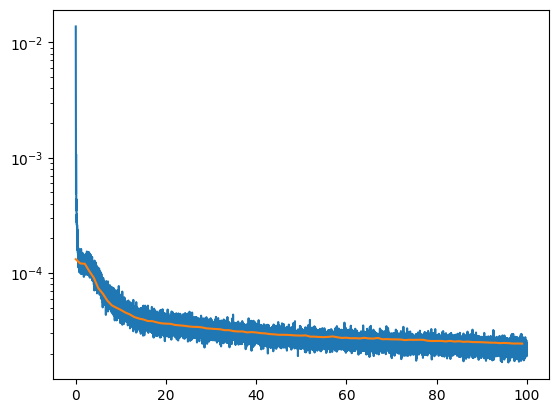

In [26]:
plt.plot(np.arange(len(CNN_model.train_loss)) / len(trn_dataloader), CNN_model.train_loss)
plt.plot(np.arange(len(CNN_model.val_loss)), CNN_model.val_loss)
plt.yscale("log")
plt.show()

In [27]:
qcd_sample=z_test_p[y_test_p==0][:4]
top_sample=z_test_p[y_test_p==1][:4]
qcd_reconstructed=CNN_model.forward(qcd_sample)
top_reconstructed=CNN_model.forward(top_sample)

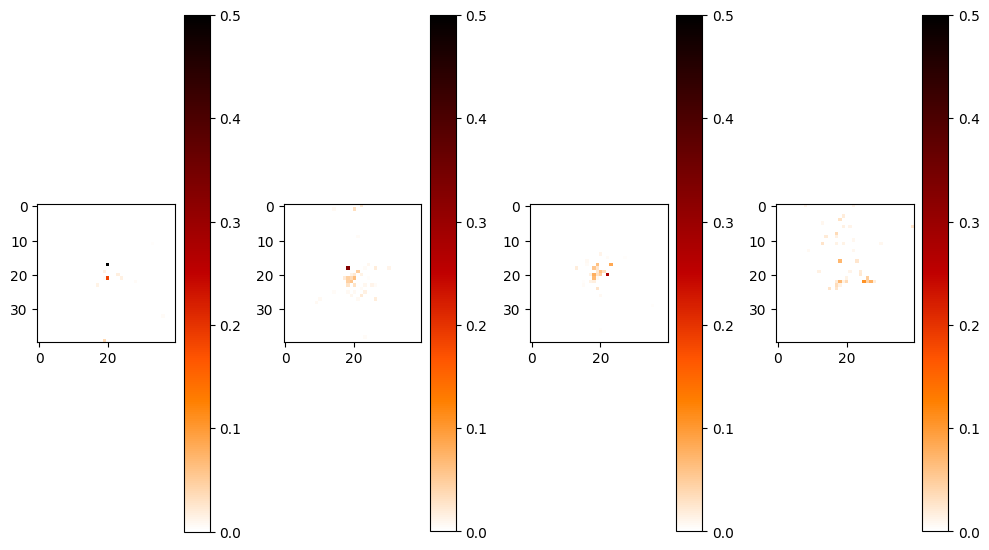

In [28]:
visualize_matrices(qcd_sample.reshape(-1, 40, 40).detach().numpy(), 1, 4)

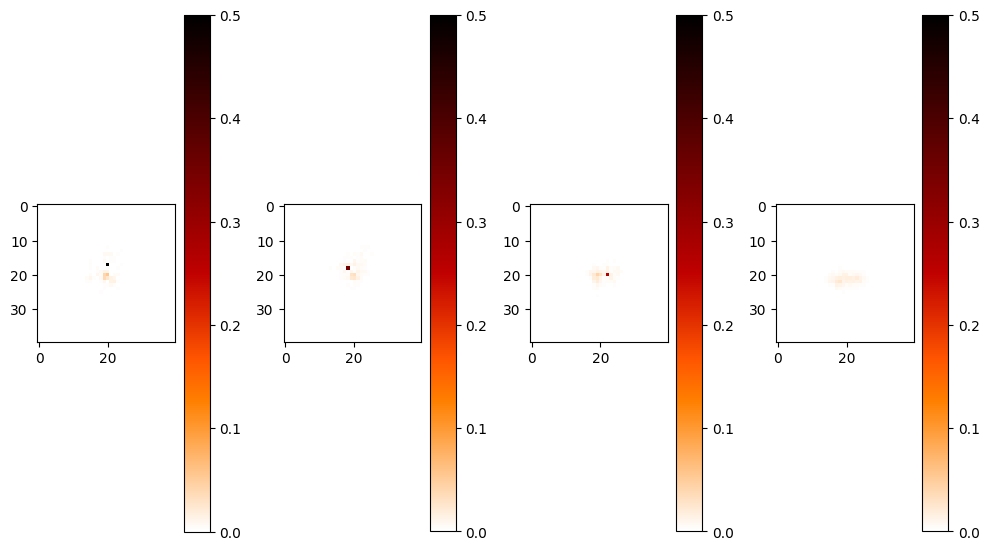

In [29]:
visualize_matrices(qcd_reconstructed.reshape(-1, 40, 40).detach().numpy(), 1, 4)

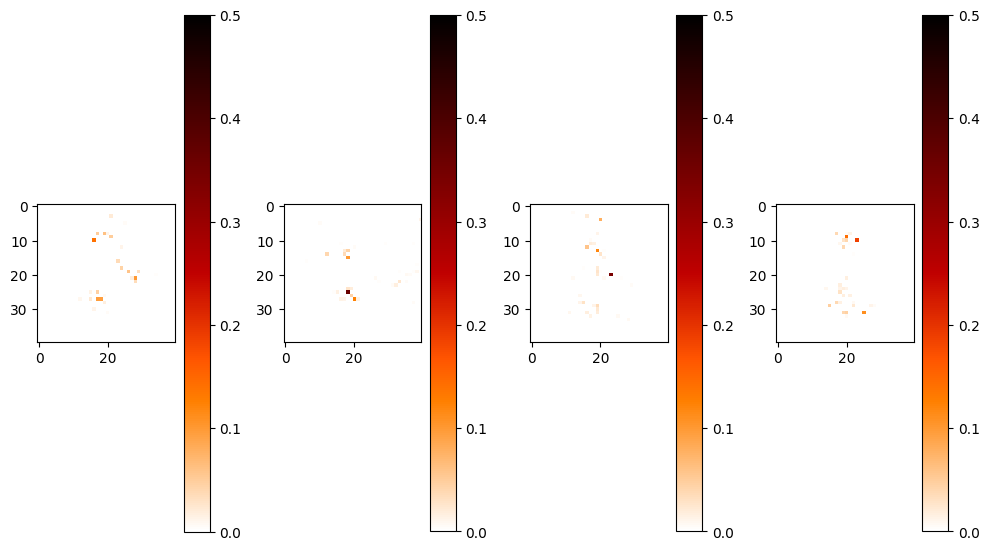

In [30]:
visualize_matrices(top_sample.reshape(-1, 40, 40).detach().numpy(), 1, 4)

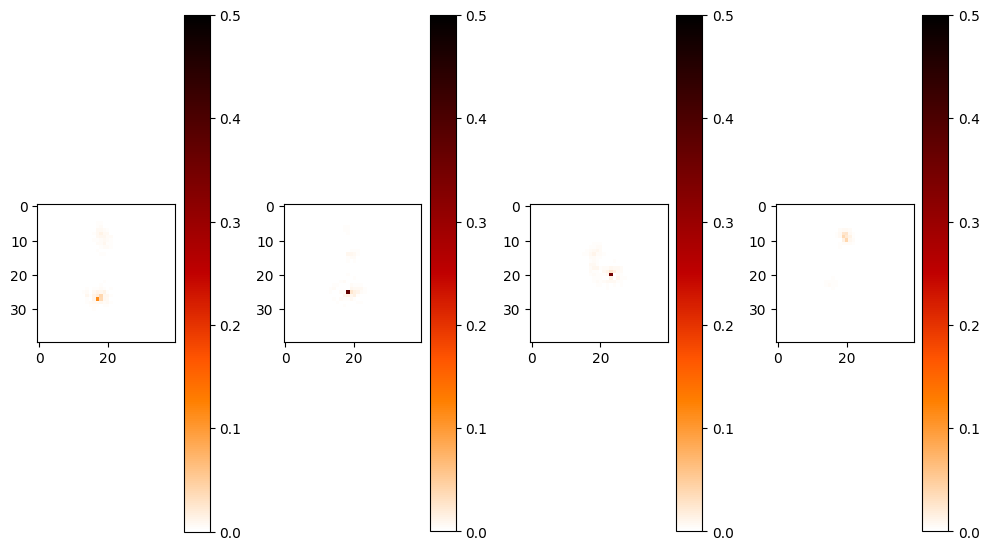

In [31]:
visualize_matrices(top_reconstructed.reshape(-1, 40, 40).detach().numpy(), 1, 4)

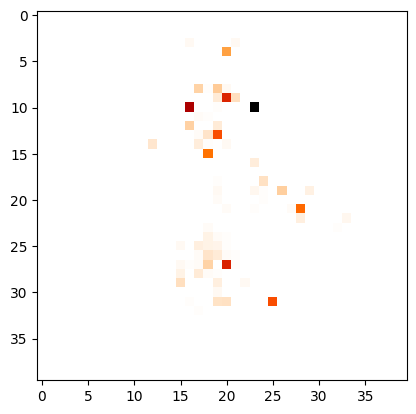

In [32]:
mse_top = ((top_sample - top_reconstructed)**2).mean(axis=0)
mse_qcd = ((qcd_sample - qcd_reconstructed)**2).mean(axis=0)
plt.imshow(mse_top.reshape(40, 40).detach().numpy(), cmap="gist_heat_r")

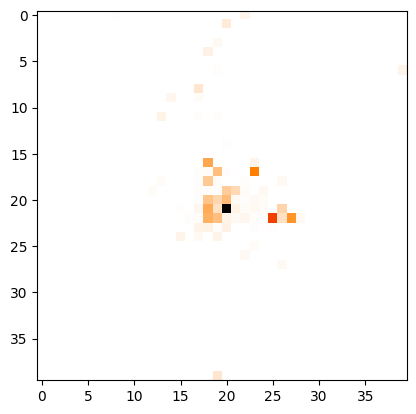

In [33]:
plt.imshow(mse_qcd.reshape(40, 40).detach().numpy(), cmap="gist_heat_r")

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_score(model, dataloader):
    model.eval()
    mse_scores = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            mse = ((inputs - outputs)**2).mean(dim=(1, 2, 3))
            mse_scores.extend(mse.tolist())
            true_labels.extend(labels.tolist())
    
    mse_scores = np.array(mse_scores)
    true_labels = np.array(true_labels)
    
    fpr, tpr, thresholds = roc_curve(true_labels, mse_scores)
    roc_auc = roc_auc_score(true_labels, mse_scores)
    
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


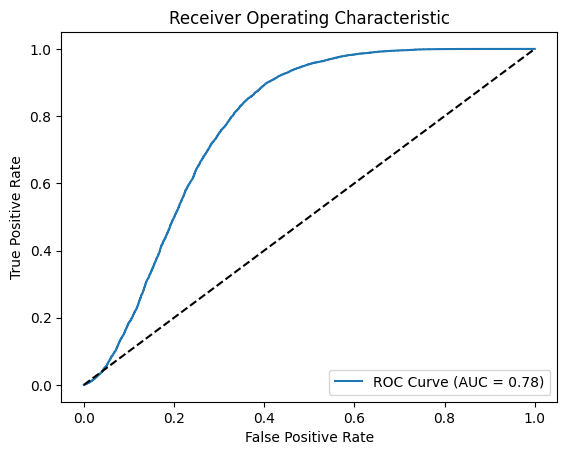

In [40]:
plot_roc_score(model, tst_dataloader)

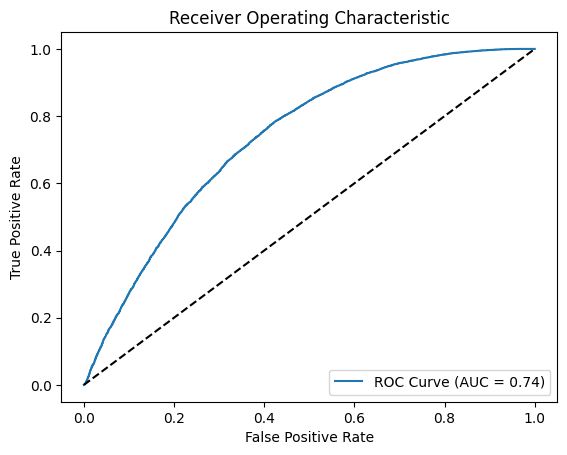

In [39]:
plot_roc_score(CNN_model, tst_dataloader)

(f)